In [109]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Approach adapted from https://www.labri.fr/perso/nrougier/from-python-to-numpy/#boids

### Begin with a 2D LJ simulation

This will be a 2-dimensional simulation of Lennard-Jones particles using all dimensionless parameters:
* Time step $t = 1$
* Particle mass $m = 1$
* Temperature $T = 1$
* LJ potential width $\sigma=1$
* LJ potential depth $\epsilon=1$

In [110]:
# Define dimensionless parameters
dt = 1.
m = 1.
kB = 1  # Boltzmann constant
L = 10.  # Simulation box size

In [201]:
# Define simulation settings
n = 25
T = 1.
sigma = 1.
epsilon = 1.
rcut = 4.
assert(rcut < L/2)
dtlog = 10 # Log to trajectory every dtlog time steps

In [169]:
# Initialize positions
pos = np.zeros((n, 2), dtype=np.float32)
nside = int(np.sqrt(n))  # For now, just assume sqrt(n) is integer... deal with general case later
lside = (4./5.) * L  # Shrink initial lattice slightly to avoid overlap of periodic images
x = np.linspace(-lside/2, lside/2, nside)
y = np.linspace(-lside/2, lside/2, nside)
X,Y = np.meshgrid(x,y)
pos_init = np.array([X.flatten(),Y.flatten()]).T
pos += pos_init
pos += np.random.uniform(0, .3, pos.shape)  #  Add some noise to break the symmetry}

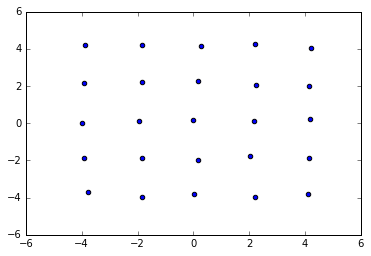

In [170]:
# Visualize uniform initial positions in simulation box
plt.scatter(pos[:,0], pos[:,1])

In [171]:
# Initialize velocities to uniform distribution with zero mean
velocity = np.zeros((n, 2), dtype=np.float32)
velocity += np.random.uniform(-.5, .5, size=(n, 2))  # Uniform random velocities
velocity -= np.mean(velocity) # Subtract the mean (no bulk flow)
# for i in range(velocity.shape[1]):
#     velocity[:,i] /= np.mean(velocity[:,i]**2)  # Scale the velocities to get desired initial temperature

In [172]:
# Determine particles within cutoff radius
dx = np.subtract.outer(pos[:, 0], pos[:, 0])
dy = np.subtract.outer(pos[:, 1], pos[:, 1])

# Apply "minimum image" convention -- particles interact only with nearest periodic image
dx[dx > L/2] -= L
dx[dx < -L/2] += L

dy[dy > L/2] -= L
dy[dy < -L/2] += L

r2 = dx**2 + dy**2  # Squared distance between all pairs of particles

# Select interaction pairs within cutoff distance (also ignore self-interactions)
mask = r2 < rcut**2
mask *= r2 > 0

In [173]:
# Define functions for computing forces and energy
def lj_potential(r2, sigma, epsilon):
    """Compute the Lennard-Jones potential
    
    Parameters
    ----------
    r2 : float or [N] numpy array
        Squared particle-particle separation.
    sigma : float
        Width of the potential, defined by distance at which potential is zero.
    epsilon : float
        Depth of the potential well, relative to the energy at infinite separation.
    
    """
    energy = 4*epsilon*((sigma**2/r2)**6 - (sigma**2/r2)**3)
    return energy

def lj_force(r2, sigma, epsilon):
    """Compute the Lennard-Jones force.
    
    Returned value is normalized by r, such that it can be multiplied by the 
    x, y or z component of r to obtain the correct cartesian component of the 
    force.
    
    Parameters
    ----------
    r2 : float or [N] numpy array
        Squared particle-particle separation.
    sigma : float
        Width of the potential, defined by distance at which potential is zero.
    epsilon : float
        Depth of the potential well, relative to the energy at infinite separation.
    
    """
    force = (48/r2)*epsilon*((sigma**2/r2)**6 - .5*(sigma**2/r2)**3)
    return force

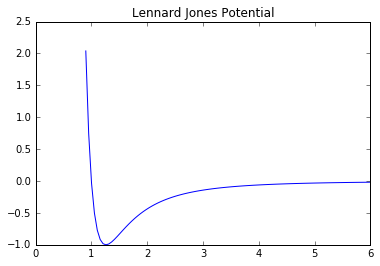

In [174]:
x = np.linspace(.9, 6, 100)
pot = lj_potential(x, 1, 1)
plt.plot(x, pot)
plt.title('Lennard Jones Potential')

In [175]:
# Compute forces and energy
energy = np.sum(lj_potential(r2[mask], sigma, epsilon))
fx = np.zeros_like(dx)
fx[mask] = dx[mask] * lj_force(r2[mask], sigma, epsilon)
fy = np.zeros_like(dy)
fy[mask] = dy[mask] * lj_force(r2[mask], sigma, epsilon)

In [204]:
# Run dynamics
pos_prev = pos - velocity*dt  # Fake the pos at time step before initial pos
nframes = 1000
traj = np.empty((nframes/dtlog, pos.shape[0], pos.shape[1]))
for i in range(nframes):
    # Determine particles within cutoff radius
    dx = np.subtract.outer(pos[:, 0], pos[:, 0])
    dy = np.subtract.outer(pos[:, 1], pos[:, 1])

    # Apply "minimum image" convention -- particles interact only with nearest periodic image
    dx[dx > L/2] -= L
    dx[dx < -L/2] += L
    dy[dy > L/2] -= L
    dy[dy < -L/2] += L
    r2 = dx**2 + dy**2  # Squared distance between all pairs of particles

    # Select interaction pairs within cutoff distance (also ignore self-interactions)
    mask = r2 < rcut**2
    mask *= r2 > 0    

    # Compute forces and energy
    energy = np.sum(lj_potential(r2[mask], sigma, epsilon))
    fx = np.zeros_like(dx)
    fx[mask] = dx[mask] * lj_force(r2[mask], sigma, epsilon)
    fy = np.zeros_like(dy)
    fy[mask] = dy[mask] * lj_force(r2[mask], sigma, epsilon)
    
    # Integrate equations of motion (Verlet)
    net_fx = np.sum(fx, axis=1)
    pos[:,0] = (2.*pos[:,0] - pos_prev[:,0] + net_fx/m*dt**2) % L  # % L accounts for PBCs
    net_fy = np.sum(fy, axis=1)
    pos[:,1] = (2.*pos[:,1] - pos_prev[:,1] + net_fy/m*dt**2) % L  # % L accounts for PBCs
    if i % dtlog == 0:
        traj[i/dtlog] = pos
    pos_prev=pos
    
    

## Visualize the trajectory

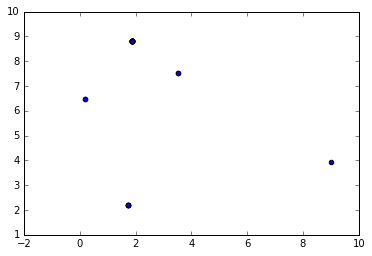

In [235]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(*traj[73].T)